In [1]:
# Torch and related packages
import torch
from torchvision import transforms, datasets, utils
import torch.nn.functional as F
from PIL import Image

# Math and plot utils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# For profiling performance
import time

# Our model which we train
from models.fast_scnn import FastSCNN
from datetime import datetime

# Custom Utilities
from utils.dataset import IGVCDataset
from utils.train_util import train_net
from utils.common_utils import load_params, save_params

In [2]:
# Setting and checking device
gpuid=0
device = torch.device('cuda:'+str(gpuid) if torch.cuda.is_available() else 'cpu')
torch.cuda.device(device)
print('Device name:', torch.cuda.get_device_properties(device).name)
print('Device id:  ', device)

Device name: GeForce 920M
Device id:   cuda:0


In [3]:
# Data Augmentation
output_h = 720          # desired height after applying transforms
output_w = 1280         # desired width after applying transforms
rotation_angle = 10.0   # range for RandomRotation (degrees)
# To ensure that RandomResizedCrop can cover the full image
ar_min = float(output_h)/float(output_w)
# To crop after RandomRotation so as to remove the padding
scale_factor = np.sin(np.arctan(ar_min))/np.sin(np.arctan(ar_min) + np.radians(rotation_angle))
crop_h = np.floor(output_h*scale_factor)
crop_w = np.floor(output_w*scale_factor)

transform = {'train': {}, 'val': {}, 'test': {}}

transform['train']['inputs'] = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomResizedCrop(size=(output_h, output_w), scale=(0.5, 1.0), 
                                     ratio=(ar_min, 4.0/3.0), interpolation=Image.BILINEAR),
        transforms.Resize(size=(output_h, output_w), interpolation=Image.BILINEAR)]),
    transforms.RandomApply(p=0.5,
        transforms=[transforms.RandomRotation(rotation_angle, resample=Image.BILINEAR),
                   transforms.CenterCrop(size=(crop_h, crop_w)),
                   transforms.Resize(size=(output_h, output_w), interpolation=Image.BILINEAR)]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.25, saturation=0.25, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
transform['train']['labels'] = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomResizedCrop(size=(output_h, output_w), scale=(0.5, 1.0), 
                                     ratio=(ar_min, 4.0/3.0), interpolation=Image.NEAREST),
        transforms.Resize(size=(output_h, output_w), interpolation=Image.NEAREST)]),
    transforms.RandomApply(p=0.5,
        transforms=[transforms.RandomRotation(rotation_angle, resample=Image.NEAREST),
                   transforms.CenterCrop(size=(crop_h, crop_w)),
                   transforms.Resize(size=(output_h, output_w), interpolation=Image.NEAREST)]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

transform['val']['inputs'] = transforms.Compose([
    transforms.Resize(size=(output_h, output_w), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
transform['val']['labels'] = transforms.Compose([
    transforms.Resize(size=(output_h, output_w), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

transform['test'] = transform['val']

# Randomized transforms for inputs and labels must be in the same order, so that when the receive the same seed 
# later, they will perform the same transform. So, spatial transforms are kept first (applied to both inputs and
# labels) and colour transforms are kept later (applied to input only). Also, for labels, interpolation mode must 
# be 'nearest' to avoid non-integer/out-of-bound labels.

In [4]:
# Loading train, val and test sets
dataloaders = {}
datasets = {}
datasizes = {}

datasets['train'] = IGVCDataset(dataset_dir='data_train', transform=transform['train'])
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=2)
datasizes['train'] = len(datasets['train'])

datasets['val'] = IGVCDataset(dataset_dir='data_val', transform=transform['val'])
dataloaders['val'] = torch.utils.data.DataLoader(datasets['val'], batch_size=4, shuffle=True, num_workers=2)
datasizes['val'] = len(datasets['val'])

datasets['test'] = IGVCDataset(dataset_dir='data_test', transform=transform['test'])
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=2)
datasizes['test'] = len(datasets['test'])

print('Number of images in each set:', datasizes)

dataiter_test = iter(dataloaders['test'])

# Defining classes and respective colors
classes = ['other', 'grass', 'lane_marker']
class_weights = [15.0, 1.0, 25.0]
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.5, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         }
class_cmap = LinearSegmentedColormap('class_cmap', cdict)
class_range = Normalize(0, len(classes) - 1)

Number of images in each set: {'train': 335, 'val': 156, 'test': 53}


In [5]:
# Loading model
in_channels = 3
spatial_dim = (output_h, output_w)
width_multiplier = 0.5
model = FastSCNN(in_channels, spatial_dim, width_multiplier, num_classes=len(classes), dropout_prob=0.25).to(device)

In [6]:
# For fine-tuning on already trained parameters
# load_params(model, './models/fast_scnn_params.pt')

Loaded model parameters from  ./models/fast_scnn_params.pt


In [7]:
# Setting hyper-parameters
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.3)
criterion = torch.nn.CrossEntropyLoss(torch.FloatTensor(class_weights).to(device))
latest_model = model

Epoch 99/99
----------
train:
  loss: 0.2188
  IoUs:
    other          : 48.52
    grass          : 92.04
    lane_marker    : 39.55
val:
  loss: 0.3137
  IoUs:
    other          : 26.02
    grass          : 82.86
    lane_marker    : 41.99


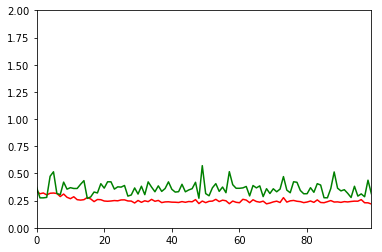

Training complete in 162m 21s
Best val loss: 0.2704
IoUs for best val loss:
  other          : 30.45
  grass          : 85.06
  lane_marker    : 40.36


In [8]:
# Training the model (run this cell multiple times for more epochs)
model, latest_model = train_net(latest_model, dataloaders, datasizes, classes,
                                criterion, optimizer_ft, exp_lr_scheduler, 
                                device, num_epochs=100)

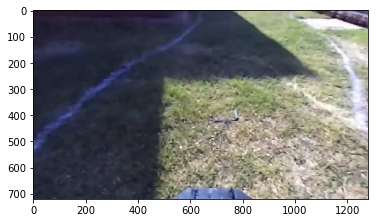

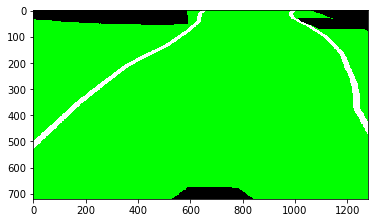

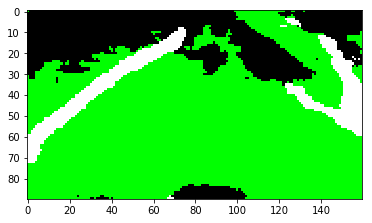

In [9]:
# For visualizing results on test set
img, label = dataiter_test.next()
pred = torch.argmax(model(img.to(device)), 1).detach().cpu()
img = transforms.Normalize(mean=[-1.0], std=[2.0])(img[0])

plt.imshow(img.permute(1, 2, 0)); plt.show()
plt.imshow(label[0][0], class_cmap, class_range); plt.show()
plt.imshow(pred[0], class_cmap, class_range); plt.show()

In [10]:
# For saving model parameters to a file
# timestamp = datetime.fromtimestamp(np.floor(time.time()))
# save_params(model, './models/fast_scnn_params.pt')
# metadata = open('./models/fast_scnn_metadata.txt', 'w')
# print(timestamp, file=metadata)
# print('in_channels:      {:d}'.format(in_channels), file=metadata)
# print('width_multiplier: {:f}'.format(width_multiplier), file=metadata)
# print('num_classes:      {:d}'.format(len(classes)), file=metadata)
# metadata.close()

Model parameters saved to  ./models/fast_scnn_params.pt


In [11]:
# Inference speed testing
gpuid=0
device = torch.device('cuda:'+str(gpuid) if torch.cuda.is_available() else 'cpu')
torch.cuda.device(device)
print('Device name:', torch.cuda.get_device_properties(device).name)

dataiter = iter(dataloaders['test'])
num_images = 40
with torch.no_grad():
    start_time = time.time()
    for i in range(num_images):
        img, label = dataiter.next()
        pred = torch.argmax(model(img.to(device)), 1).detach().cpu()
    end_time = time.time()

print('Results are as following:')
print('FPS    : {:.3f} fps'.format(num_images/(end_time - start_time)))
print('Latency: {:.3f} seconds'.format((end_time - start_time)/num_images))

Device name: GeForce 920M
Results are as following:
FPS    : 10.702 fps
Latency: 0.093 seconds
